In [15]:
# Embedded GeneExpressionMatrix class
import numpy as np

class GeneExpressionMatrix:
    def __init__(self, num_cells, num_genes=50):
        self.num_cells = num_cells
        self.num_genes = num_genes
        self.expression_matrix = np.zeros((num_cells, num_genes))

    def initialize_gene_expression(self, baseline_expression=10, noise_std=2):
        self.expression_matrix = np.random.normal(
            loc=baseline_expression, scale=noise_std, size=(self.num_cells, self.num_genes)
        )
        self.expression_matrix = np.clip(self.expression_matrix, a_min=0, a_max=None)

    def add_spatial_effects(self, spatial_factors, cell_positions=None):

        for i in range(len(cell_positions)):  # Ensure we use the correct size of cell_positions
            if cell_positions[i] is not None:
                distance_from_center = np.linalg.norm(cell_positions[i])
                self.expression_matrix[i] *= spatial_factors[i] * (1 + 0.1 * np.exp(-distance_from_center))

    

    def add_cell_type_effects(self, cell_types, type_effects):
        for i, cell_type in enumerate(cell_types):
            if cell_type in type_effects:
                self.expression_matrix[i] *= type_effects[cell_type]

    def add_noise(self, noise_std=0.5):
        noise = np.random.normal(loc=0, scale=noise_std, size=self.expression_matrix.shape)
        self.expression_matrix += noise
        self.expression_matrix = np.clip(self.expression_matrix, a_min=0, a_max=None)

    def update_for_time(self, time_step, cycle_duration=10):
        phase = (time_step % cycle_duration) / cycle_duration
        division_related_genes = np.random.choice(self.num_genes, size=10, replace=False)
        self.expression_matrix[:, division_related_genes] *= (1 + 0.5 * np.sin(np.pi * phase))
        self.expression_matrix = np.clip(self.expression_matrix, a_min=0, a_max=None)

    def apply_gene_interactions(self, interaction_matrix, interaction_strength=0.1):
        for i in range(self.num_cells):
            for gene1 in range(self.num_genes):
                for gene2 in range(self.num_genes):
                    if interaction_matrix[gene1, gene2] != 0:
                        self.expression_matrix[i, gene1] += interaction_matrix[gene1, gene2] * self.expression_matrix[i, gene2] * interaction_strength
        self.expression_matrix = np.clip(self.expression_matrix, a_min=0, a_max=None)

    def simulate_spatial_diffusion(self, diffusion_rate=0.1, time_steps=100):
        for _ in range(time_steps):
            for i in range(self.num_cells):
                neighbors = [i - 1, i + 1]
                for neighbor in neighbors:
                    if 0 <= neighbor < self.num_cells:
                        self.expression_matrix[i] += diffusion_rate * (self.expression_matrix[neighbor] - self.expression_matrix[i])
            self.expression_matrix = np.clip(self.expression_matrix, a_min=0, a_max=None)

    def get_matrix(self):
        return self.expression_matrix


['Negative bubbles', 'Positive bubbles', 'Precritical bubbles', 'Worms and loops', 'Stable solitons', 'The U-Skate World', 'Worms', 'Worms join into maze', 'Negatons', 'Turing patterns', 'Chaos to Turing negatons', 'Fingerprints', 'Chaos with negatons', 'Spots and worms', 'Self-replicating spots', 'Super-resonant mazes', 'Mazes', 'Mazes with some chaos', 'Chaos', 'Pulsating solitons', 'Warring microbes', 'Spots and loops', 'Moving spots', 'Waves']


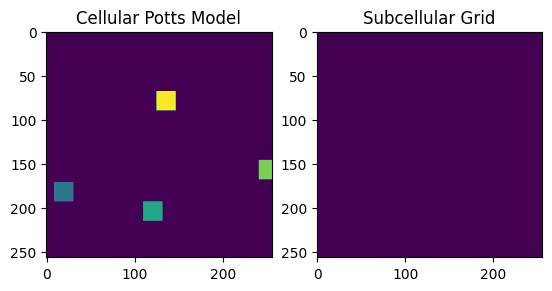

In [2]:
import torch
from multiomicscellsim.torch_cpm.config import TorchCPMConfig
from multiomicscellsim.torch_cpm.simulation import TorchCPM
import matplotlib.pyplot as plt
from multiomicscellsim.patterns.reaction_diffusion import RDPatternLibrary
import numpy as np
import matplotlib.pyplot as plt

print(RDPatternLibrary.get_pattern_names())

size = 256
volume_perc = lambda x: int(size*size*x)
cpm_config = TorchCPMConfig(
    size=size,
    preferred_volumes=torch.tensor([0, .4, .2, .2, .2]),
    preferred_perimeters=torch.tensor([3, 5, 3, 3, 2]),
    adhesion_matrix=torch.tensor([[0, 10, 10, 10, 10],
                                    [10, 0, 2, 3, 4],
                                    [10, 2, 0, 5, 6],
                                    [10, 3, 5, 0, 7],
                                    [10, 4, 6, 7, 0]]),
    frontier_prob=0.5,
    temperature=1,
    run_rd_every = 100,
    cell_types_patterns = [RDPatternLibrary.get_pattern_by_name("The U-Skate World"), 
                           RDPatternLibrary.get_pattern_by_name("Worms and loops"), 
                           RDPatternLibrary.get_pattern_by_name("Negatons"), 
                           RDPatternLibrary.get_pattern_by_name("Fingerprints"), 
                           RDPatternLibrary.get_pattern_by_name("Self-replicating spots")]
)

cpm = TorchCPM(cpm_config)

# Pick random x/y locations and draw a cell
for cell_type in range(1, 5):
    x = torch.randint(0, size, (1,))
    y = torch.randint(0, size, (1,))
    cpm.draw_cell(x, y, cell_type=cell_type)
cpm.plot_grid()

# TODO: BASE EVERYTHING ON CELL TYPES AGAIN AND NOT ON CELL_ID
# FIXME: Something's going on with the pasting of the subcellular structures (see output)

100%|██████████| 10000/10000 [00:01<00:00, 5879.35it/s]


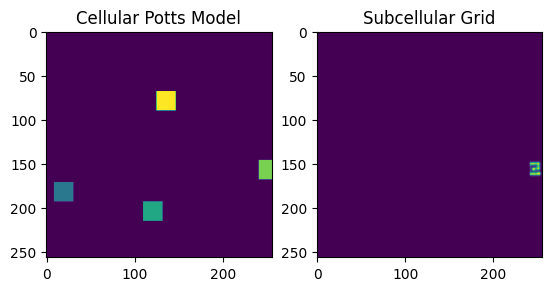

100%|██████████| 10000/10000 [00:01<00:00, 6232.48it/s]


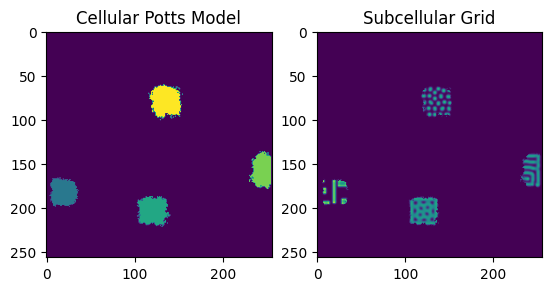

100%|██████████| 10000/10000 [00:02<00:00, 4890.45it/s]


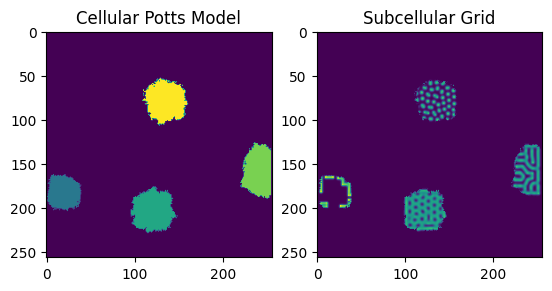

100%|██████████| 10000/10000 [00:02<00:00, 4846.04it/s]


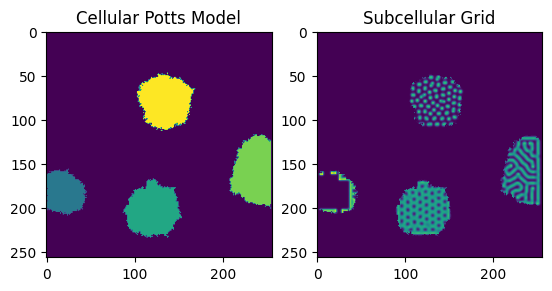

100%|██████████| 10000/10000 [00:02<00:00, 3903.89it/s]


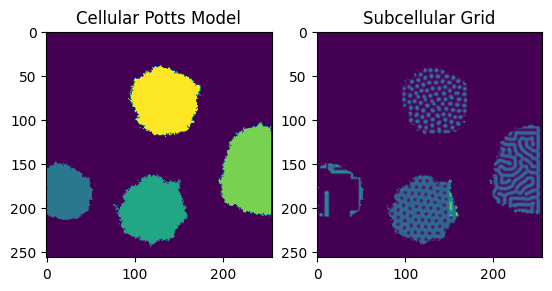

100%|██████████| 500/500 [01:29<00:00,  5.57it/s]


In [3]:
simulation = cpm.yield_step(500)
for s, step in enumerate(simulation):
    if s % 100 == 0:
        cpm.plot_grid()

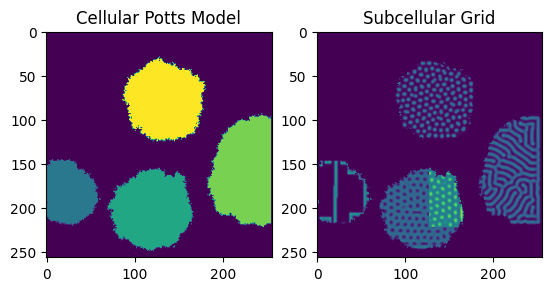

In [4]:
cpm.plot_grid()

In [19]:
print("Cell IDs:", cell_ids)
print("Extracted Positions:", len(cell_positions))



Cell IDs: [0 1 2 3 4]
Extracted Positions: 4


## Generating a gene expression matrix from the selected timestep

In [20]:
valid_cell_ids = []
cell_positions = []

for cell_id in cell_ids:
    positions = np.argwhere(grid_numpy == cell_id)
    if positions.size > 0:  # Include only cells with valid positions
        cell_positions.append(np.mean(positions, axis=0))
        valid_cell_ids.append(cell_id)  # Keep track of valid cell IDs

cell_positions = np.array(cell_positions)
num_cells = len(valid_cell_ids)  # Update num_cells to match valid cell IDs


In [21]:
spatial_factors = np.linspace(1, 2, num_cells)  # Match size with valid cells
cell_types = ["type1" if i % 2 == 0 else "type2" for i in range(num_cells)]


Number of valid cell_positions: 4
Number of valid cells (num_cells): 4


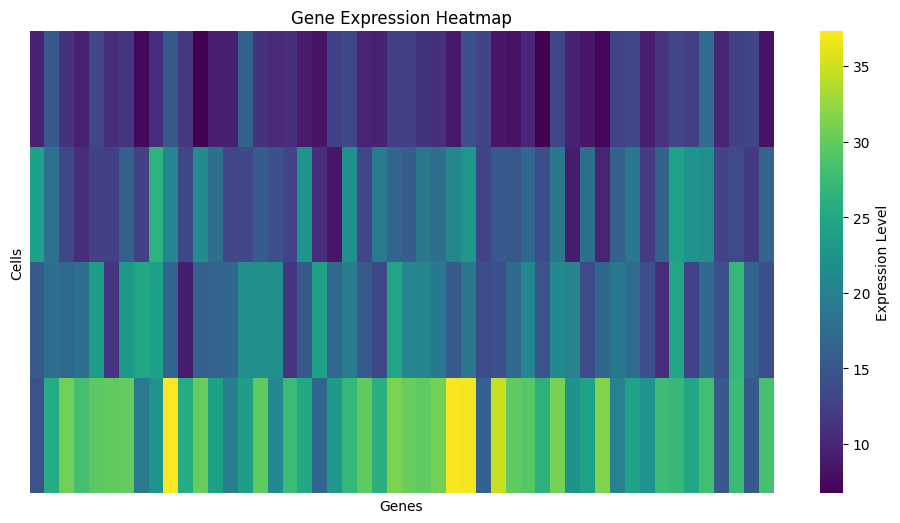

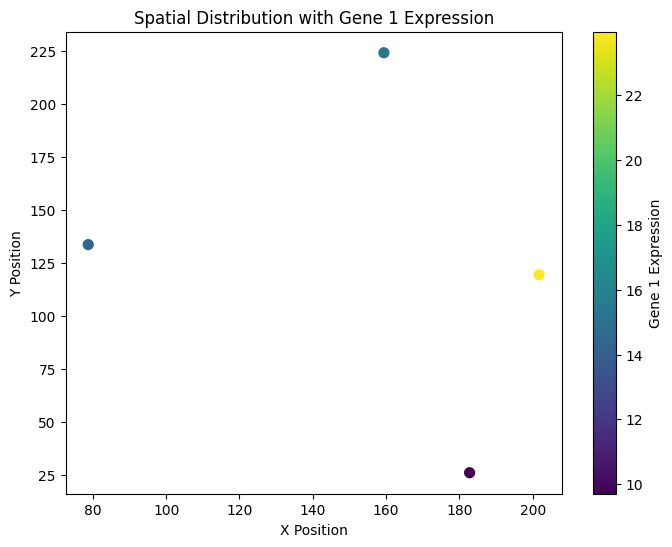

In [23]:
import seaborn as sns

# Step 1: Extract cell IDs and spatial positions from CPM simulation
cell_ids = np.unique(cpm.cell_types)  # Get unique cell IDs/types
grid_numpy = cpm.grid.cpu().numpy() if hasattr(cpm.grid, 'cpu') else cpm.grid.numpy()

valid_cell_ids = []
cell_positions = []

for cell_id in cell_ids:
    positions = np.argwhere(grid_numpy == cell_id)
    if positions.size > 0:  # Include only valid cells
        cell_positions.append(np.mean(positions, axis=0))
        valid_cell_ids.append(cell_id)

cell_positions = np.array(cell_positions)
num_cells = len(valid_cell_ids)  # Update num_cells to match valid cells

print(f"Number of valid cell_positions: {len(cell_positions)}")
print(f"Number of valid cells (num_cells): {num_cells}")

# Step 2: Initialize the Gene Expression Matrix (GEM)
gem = GeneExpressionMatrix(num_cells)

# Step 3: Simulate gene expression
gem.initialize_gene_expression()

# Add spatial effects using positions from CPM
spatial_factors = np.linspace(1, 2, num_cells)  # Match size
gem.add_spatial_effects(spatial_factors, cell_positions=cell_positions)

# Add cell type-based effects
cell_types = ["type1" if i % 2 == 0 else "type2" for i in range(num_cells)]  # Match size
type_effects = {
    "type1": np.random.uniform(0.8, 1.2, size=gem.num_genes),
    "type2": np.random.uniform(1.0, 1.5, size=gem.num_genes),
}
gem.add_cell_type_effects(cell_types, type_effects)

# Retrieve the final gene expression matrix
gene_expression_matrix = gem.get_matrix()

# Visualization (Heatmap and Spatial Distribution)
plt.figure(figsize=(12, 6))
sns.heatmap(
    gene_expression_matrix,
    cmap="viridis",
    xticklabels=False,
    yticklabels=False,
    cbar_kws={'label': 'Expression Level'}
)
plt.title("Gene Expression Heatmap")
plt.xlabel("Genes")
plt.ylabel("Cells")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(
    cell_positions[:, 0], 
    cell_positions[:, 1], 
    c=gene_expression_matrix[:, 0],  # Expression levels of Gene 1
    cmap="viridis", 
    s=50
)
plt.colorbar(label="Gene 1 Expression")
plt.title("Spatial Distribution with Gene 1 Expression")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()


## Spatial Scatter Plots with Gene-Specific Subplots

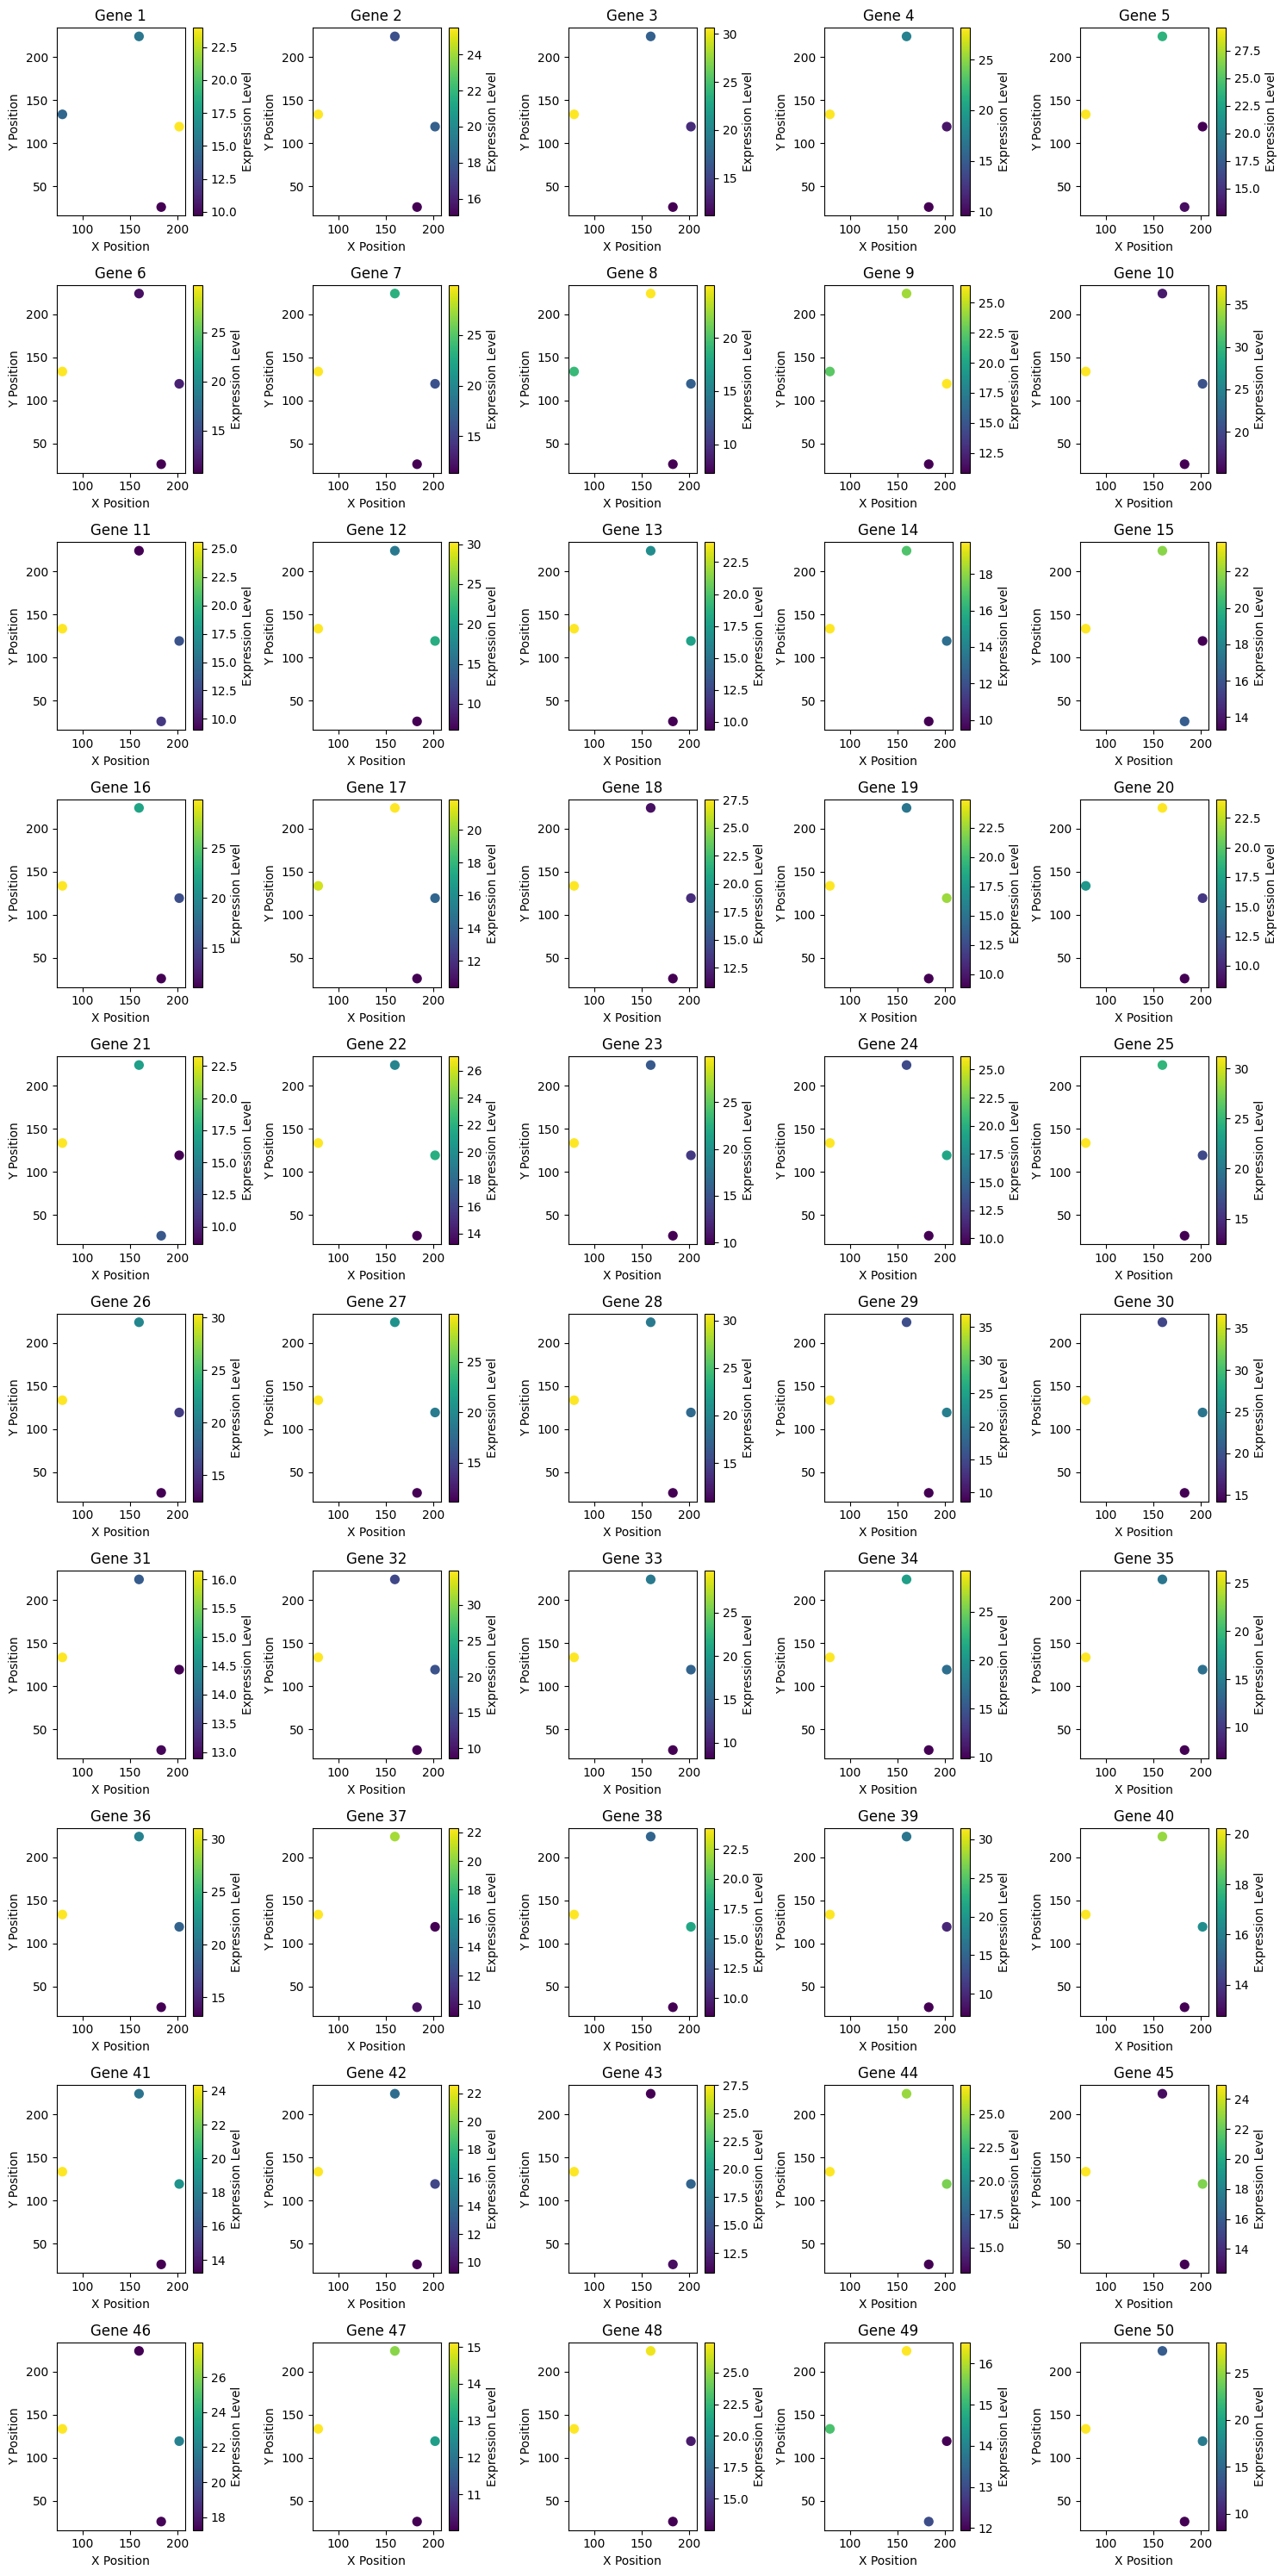

In [24]:
import matplotlib.pyplot as plt

# Number of genes to visualize
num_genes = gem.num_genes

# Determine grid size for subplots
rows = int(np.ceil(num_genes / 5))  # Adjust the divisor to control number of columns
cols = min(num_genes, 5)

# Create figure
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

for i, ax in enumerate(axes.flat[:num_genes]):
    scatter = ax.scatter(
        cell_positions[:, 0],
        cell_positions[:, 1],
        c=gene_expression_matrix[:, i],
        cmap="viridis",
        s=50
    )
    ax.set_title(f"Gene {i + 1}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    fig.colorbar(scatter, ax=ax, label="Expression Level")

# Adjust layout
plt.tight_layout()
plt.show()
